# **Markov Decision Processes**

This week's methods we will build a __M__arkov __D__ecision __P__rocess and solve it using Value Iteration. In the broadest sense, an MDP is defined by how it changes states and how rewards are computed.

State transition is defined by $P(s' |s,a)$ - how likely are you to end at state $s'$ if you take action $a$ from state $s$. Now there's more than one way to define rewards, but we'll use $r(s,a,s')$ function for convenience.



For starters, let's define a simple MDP from this picture:

<img src="https://upload.wikimedia.org/wikipedia/commons/a/ad/Markov_Decision_Process.svg" width="400px" alt="Diagram by Waldoalvarez via Wikimedia Commons, CC BY-SA 4.0"/>

We start by instaling the MDP library that we will use throughout the workshop.

In [1]:
!pip install mdp

And we now mount our Drive to make use of the additional files. Here I have put these on the Colab Notebooks directoy on my Drive. If you use a different directory, the path should be changed accordingly.

In [2]:
 from google.colab import drive
 import sys
 drive.mount('/content/drive')
 sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks')
 import mdp

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We will now setup the practical scrpt and the virtual display for the visualisation tasks throughout. The cell may have to be run a couple of times so as to allow xvfb to start.

In [3]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
  # Insert the directoryimport sys
  # Run the scripts
  !setup_colab_practical3.sh -O- | bash
  !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

bash: ../xvfb: No such file or directory


In [4]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.4, 's4': 0.2, 's1':0.1,'s2':0.1,'s3':0.1,'s5':0.1},
        'a1': {'s1': 0.4, 's5':0.2,'s2':0.1,'s3':0.1,'s4':0.1,'s0':0.1},
        'a2': {'s2': 0.4, 's3': 0.2, 's0':0.1,'s1':0.1,'s4':0.1,'s5':0.1}
    },
    's1': {
        'a0': {'s0': 0.4, 's4': 0.2, 's1':0.1,'s2':0.1,'s3':0.1,'s5':0.1},
        'a1': {'s1': 0.4, 's5':0.2,'s2':0.1,'s3':0.1,'s4':0.1,'s0':0.1},
        'a2': {'s2': 0.4, 's3': 0.2, 's0':0.1,'s1':0.1,'s4':0.1,'s5':0.1}
    },
    's2': {
        'a0': {'s0': 0.4, 's4': 0.2, 's1':0.1,'s2':0.1,'s3':0.1,'s5':0.1},
        'a1': {'s1': 0.4, 's5':0.2,'s2':0.1,'s3':0.1,'s4':0.1,'s0':0.1},
        'a2': {'s2': 0.4, 's3': 0.2, 's0':0.1,'s1':0.1,'s4':0.1,'s5':0.1}
    },
    's3': {
        'a0': {'s0': 0.4, 's4': 0.2, 's1':0.1,'s2':0.1,'s3':0.1,'s5':0.1},
        'a1': {'s1': 0.4, 's5':0.2,'s2':0.1,'s3':0.1,'s4':0.1,'s0':0.1},
        'a2': {'s2': 0.4, 's3': 0.2, 's0':0.1,'s1':0.1,'s4':0.1,'s5':0.1}
    },
    's4': {
        'a0': {'s0': 0.4, 's4': 0.2, 's1':0.1,'s2':0.1,'s3':0.1,'s5':0.1},
        'a1': {'s1': 0.4, 's5':0.2,'s2':0.1,'s3':0.1,'s4':0.1,'s0':0.1},
        'a2': {'s2': 0.4, 's3': 0.2, 's0':0.1,'s1':0.1,'s4':0.1,'s5':0.1}
    },
    's5': {
        'a0': {'s0': 0.4, 's4': 0.2, 's1':0.1,'s2':0.1,'s3':0.1,'s5':0.1},
        'a1': {'s1': 0.4, 's5':0.2,'s2':0.1,'s3':0.1,'s4':0.1,'s0':0.1},
        'a2': {'s2': 0.4, 's3': 0.2, 's0':0.1,'s1':0.1,'s4':0.1,'s5':0.1}
    }
}
rewards = {
    's0': {'a0': {'s0': 5}},
    's0': {'a0': {'s4': -5}},
    's0': {'a1': {'s1': -5}},
    's0': {'a2': {'s3': -5}},
    's1': {'a0': {'s0': 5}},
    's1': {'a0': {'s4': -5}},
    's1': {'a1': {'s1': -5}},
    's1': {'a2': {'s3': -5}},
    's2': {'a0': {'s0': 5}},
    's2': {'a0': {'s4': -5}},
    's2': {'a1': {'s1': -5}},
    's2': {'a2': {'s3': -5}},
    's3': {'a0': {'s0': 5}},
    's3': {'a0': {'s4': -5}},
    's3': {'a1': {'s1': -5}},
    's3': {'a2': {'s3': -5}},
    's4': {'a0': {'s0': 5}},
    's4': {'a0': {'s4': -5}},
    's4': {'a1': {'s1': -5}},
    's4': {'a2': {'s3': -5}},
    's5': {'a0': {'s0': 5}},
    's5': {'a0': {'s4': -5}},
    's5': {'a1': {'s1': -5}},
    's5': {'a2': {'s3': -5}}

}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')
import numpy as np

We can now use MDP just as any other gym environment:

In [5]:
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('a1')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))

initial state = s0
next_state = s0, reward = 0.0, done = False


but it also has other methods that you'll need for Value Iteration

In [6]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s0') = ", mdp.get_possible_actions('s1'))
print("mdp.get_next_states('s0', 'a1') = ", mdp.get_next_states('s1', 'a0'))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("mdp.get_transition_prob('s0', 'a1', 's0') = ", mdp.get_transition_prob('s1', 'a0', 's0'))

mdp.get_all_states = ('s0', 's1', 's2', 's3', 's4', 's5')
mdp.get_possible_actions('s0') =  ('a0', 'a1', 'a2')
mdp.get_next_states('s0', 'a1') =  {'s0': 0.4, 's4': 0.2, 's1': 0.1, 's2': 0.1, 's3': 0.1, 's5': 0.1}
mdp.get_reward('s1', 'a0', 's0') =  0.0
mdp.get_transition_prob('s0', 'a1', 's0') =  0.4


## **Visualising MDPs**

You can visualize any MDP with the drawing fuction donated by [neer201](https://github.com/neer201). To do so, we have to install graphviz.

In [7]:
from mdp import has_graphviz
from IPython.display import display
print("Graphviz available:", has_graphviz)

Graphviz available: True


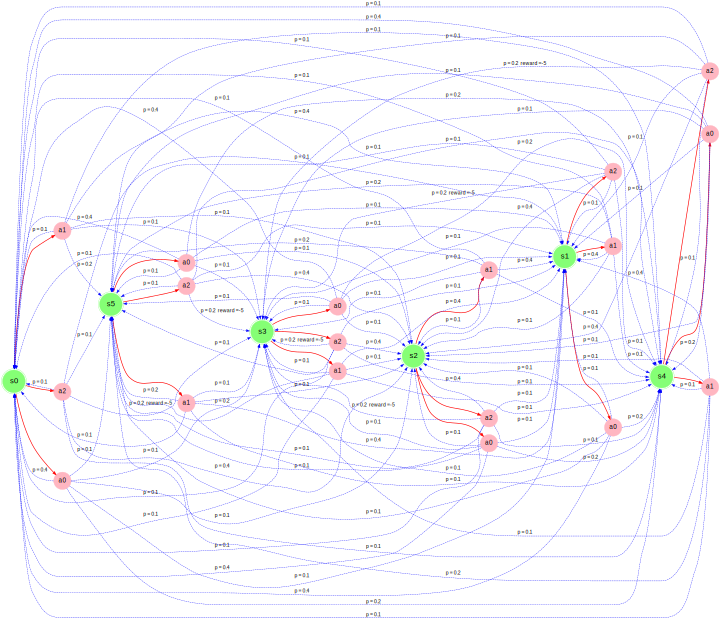

In [8]:
if has_graphviz:
    from mdp import plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values
    display(plot_graph(mdp))

## **Value Iteration**

The simplest algorithm so far is __V__alue __I__teration

Here's the pseudo-code for VI:

---

`1.` Initialize $V^{(0)}(s)=0$, for all $s$

`2.` For $i=0, 1, 2, \dots$
 
`3.` $ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, for all $s$

---

First, let's write a function to compute the state-action value function $Q({\pi})$, defined as follows

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$

Using $Q(s,a)$ we can now define the "next" V(s) for value iteration.
 $$V_{i+1}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

Now let's use those $V_{i+1}(s)$ to find optimal actions in each state

 $$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$
 
The only difference vs V(s) is that here we take not max but argmax: find action such with maximum Q(s,a).

Thus, we now commence by defining a function that will return the action value.


With the action in hand, we can now define a function to return the state value

Finally, let's combine everything we wrote into a working value iteration algorithm

Finally, we can now plot the final graphical model

Also, we can now look at te final state values.

In [9]:
# Compute the Q-value using the formula above
def get_action_value(mdp, state_values, state, action, gamma):

    # Initialise Q 
    Q = 0  
    for s in mdp.get_all_states():
      # Compute Q using the equation above
      Q = Q + mdp.get_transition_prob(state, action[s], s)*(mdp.get_reward(state, action[s], s) + gamma*state_values[s]) 
    return Q

In [10]:
# Compute the Q-value using the formula above
def get_action_value_max(mdp, state_values, state, action, gamma):

    # Initialise Q 
    Q = 0  
    for s in mdp.get_all_states():
      # Compute Q using the equation above
      Q = Q + mdp.get_transition_prob(state, action, s)*(mdp.get_reward(state, action, s) + gamma*state_values[s]) 
    return Q

In [11]:
def policy_eval(mdp, state_value_dict, state_action_dict, state_act_val):
  import random
  #Intialization

  for s in mdp.get_all_states():
    state_value_dict[s] = 5
    a = mdp.get_possible_actions(s)
    state_action_dict[s] = random.sample(a, 1)[0]
    print(state_action_dict)
    

  
  for i in range(0, 100):
    delta = 0
    for s in mdp.get_all_states():
      v = state_value_dict[s]
      V = get_action_value(mdp,state_value_dict, s, state_action_dict, 0.9)
      delta =  max( delta, abs(v - V))
      print("iter %4i   |   delta: %6.5f   |   " % (i, delta), end="")
      print('   '.join("V(%s) = %.3f" % (s, v) for s, v in state_value_dict.items()))
      state_value_dict[s] = V

    if delta <= 0.01:
      print('terminated....')
      break
  
  return state_value_dict, state_action_dict




  
  

In [12]:
def policy_improv(mdp, state_value_dict, state_action_dict, state_act_val):
  policy_stable = True
  for s in mdp.get_all_states():
    old_action = state_action_dict[s]
    
    # recomputer π∗(s) using new values from policy_eval
    #i = 0
    V = []
    A = []
    for a in mdp.get_possible_actions(s):
      V.append(get_action_value_max(mdp, state_value_dict, s, a, 0.9))
      A.append(a)
      #i += 1
    new_action = A[np.argmax(V)]

    if old_action != new_action:
      policy_stable = False
    
    state_act_val[s] = {A[np.argmax(V)]:V[np.argmax(V)]}
  return policy_stable, state_act_val
    
    




In [14]:
policy_stable = False
state_act_val = {}
state_value_dict = {}
state_action_dict = {}
while policy_stable == False:
  state_value_dict, state_action_dict = policy_eval(mdp,state_value_dict,state_action_dict, state_act_val)
  policy_stable, _ = policy_improv(mdp, state_value_dict, state_action_dict, state_act_val)
  print('policy stable? ->',policy_stable)




Streaming output truncated to the last 5000 lines.
iter   34   |   delta: 119343794.71660   |   V(s0) = 194042907.177   V(s1) = 221812571.019   V(s2) = 253556377.699   V(s3) = 289843070.555   V(s4) = 180869204.780   V(s5) = 187340295.490
iter   34   |   delta: 123613645.53089   |   V(s0) = 194042907.177   V(s1) = 221812571.019   V(s2) = 253556377.699   V(s3) = 289843070.555   V(s4) = 300212999.497   V(s5) = 187340295.490
iter   35   |   delta: 128036261.94158   |   V(s0) = 194042907.177   V(s1) = 221812571.019   V(s2) = 253556377.699   V(s3) = 289843070.555   V(s4) = 300212999.497   V(s5) = 310953941.021
iter   35   |   delta: 146359652.39883   |   V(s0) = 322079169.119   V(s1) = 221812571.019   V(s2) = 253556377.699   V(s3) = 289843070.555   V(s4) = 300212999.497   V(s5) = 310953941.021
iter   35   |   delta: 167305320.58238   |   V(s0) = 322079169.119   V(s1) = 368172223.418   V(s2) = 253556377.699   V(s3) = 289843070.555   V(s4) = 300212999.497   V(s5) = 310953941.021
iter   35   | 

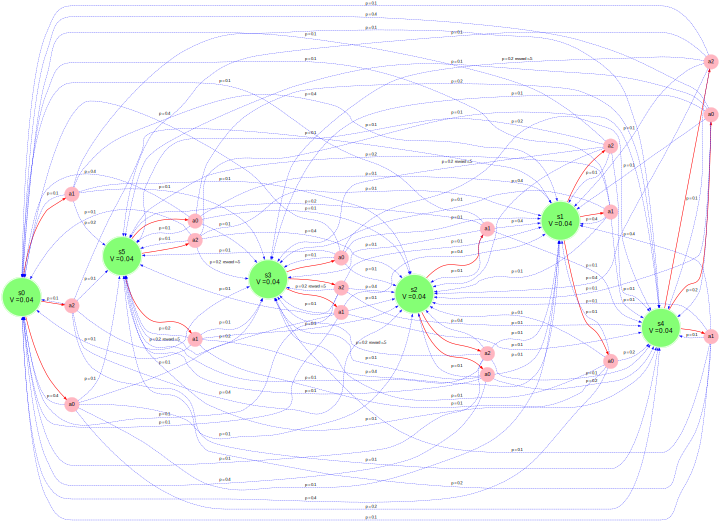

In [15]:
if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_value_dict))

In [22]:
print("Final state values:", state_value_dict)

Final state values: {'s0': 0.04939369203728545, 's1': 0.04614350993168626, 's2': 0.04538443117039274, 's3': 0.04463783955120653, 's4': 0.04390352965576268, 's5': 0.04245906923405449}
